In [1]:
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split

     |████████████████████████████████| 42 kB 311 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_columns=30

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

## DATA CLEANING AND PRE-PROSESSING

### Cargamos el DataSet, seteamos los ID's de los clientes como el INDICE de nuesto DF y separamos la columna que será el TARGET.

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_.csv', index_col=0)
target_col = ['TIENE_PRESTAMO_PERSONAL']

### Ahora, para que nuestro modelo también se pueda entrenar con las variables categóricas MÁS IMPORTANTES, vamos a convertirLas a enteros mediante la sustitución por una etiqueta:
SEXO = {'M' -> 0, 'H' -> 1, 'F' -> 2}

NSE = {'G' -> 0, 'F' -> 1, 'E' -> 2. 'D' -> 3, 'C' -> 4, 'B' -> 5, 'A' -> 6}

UTILIZACION_TC = {'bajo' -> 0, 'medio' -> 1, 'alto' -> 2}

UTILIZACION_TD = {'bajo' -> 0, 'medio' -> 1, 'alto' -> 2}

CLASIFICACION_VALOR_MAC = {'muy bajo' -> 0, 'bajo' -> 1, 'medio' -> 2, 'alto' -> 3, 'muy alto' -> 4}

SEGMENTO360 = {'Clientes Otros' -> 0, 'Clientes Ctas Soc/Especiales' ->1, 'Clientes Cuenta Sueldo' -> 0}

Finalemte se observa que la variable 'Canal_Comercializacion' tiene aproximadamente la mitad de sus entradas con valores no nulos, por lo que transformaremos los datos nulos a -1 y el resto de las categorías las convertiremos a enteros.


In [12]:
df['SEXO'] = df['SEXO'].replace(['M', 'H', 'F'  ], [0, 1, 2]).astype('Int64')
df['UTILIZACION_TC'] = df['UTILIZACION_TC'].replace(['bajo', 'medio', 'alto'], [0, 1, 2]).astype('Int64')
df['UTILIZACION_TD'] = df['UTILIZACION_TD'].replace(['bajo', 'medio', 'alto'], [0, 1, 2]).astype('Int64')
df['CLASIFICACION_VALOR_MAC'] = df['CLASIFICACION_VALOR_MAC'].replace(['muy bajo', 'bajo', 'medio', 'alto', 'muy alto'], [0, 1, 2, 3, 4]).astype('Int64')
df['NSE'] = (df['NSE'].replace(['G', 'F', 'E', 'D', 'C', 'B', 'A'], [0, 1, 2, 3, 4, 5, 6])).astype(float).astype('Int64')
df['SEGMENTO360'] = df['SEGMENTO360'].replace(['Clientes Otros', 'Clientes Ctas Soc/Especiales', 'Clientes Cuenta Sueldo'], [0, 1, 2]).astype('Int64')
df['Canal_Comercializacion'] = df['Canal_Comercializacion'].replace([np.nan, 'Digital', 'Sucursal', 'ATM', 'ComercioAliado'], [-1, 0, 1, 2, 3])
df.head(3)

,Canal_Comercializacion,SEXO,EDAD,ANIOS_ANTIGUEDAD,SUCURSAL_ACREDITACION,SEGMENTO360,CLASIFICACIONCLIENTE,UTILIZACION_TC,UTILIZACION_TD,CLASIFICACION_VALOR_MAC,BANCON_ACTIVO1,CANTIDAD_PRODUCTOS,TIENE_CAJA_AHORRO,TIENE_TARJETA_CREDITO,TIENE_PRESTAMO_PERSONAL,TIENE_PRESTAMO_HIPOTECARIO,CANTIDAD_PRESTAMOS_HIPOTECARIOS,USA_CUENTA_CORRIENTE,USA_CUENTA_ADELANTO,TIENE_SEGURO_VIDA,TIENE_SEGURO_PATRIMONIAL,TIENE_PLAZO_FIJO,TIENE_FONDO_COMUN_INVERSION,TIENE_DOLARES,TIENE_CAJA_SEGURIDAD,INGRESO,NSE,ROL_MONOTIIBB,REGIMEN_MONOT_IIBB
ID_CLiente_BP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49950,-1,2,73,13,326,2,BI JUBILADOS ANSES,1,1,3,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,18410,0,sd,sd
49951,-1,2,73,20,302,2,BI JUBILADOS PROVINCIA,0,0,4,1,3,1,1,0,0,0,0,0,0,0,0,0,1,0,50473,3,sd,sd
49965,-1,2,76,18,429,2,BI JUBILADOS PROVINCIA,<NA>,2,3,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,56184,3,sd,sd


En las columas de variables categóricas con una gran cantidad de categorías, vamos a agrupar todas las categorías con baja ocurrenci en una nueva llamada 'other'. 

Además, necesitamos que las columnas con tipos de datos 'str' sean valores enteros.

Se observa que la variable 'Canal_Comercializacion' tiene aproximadamente la mitad de sus entradas con valores no nulos, por lo que transformaremos los datos nulos a -1 y el resto de las categorías las convertiremos a enteros.

Finalmente, como se puede observar en las tablas a continuación, descartamos las columnas 'ROL_MONOTIIBB' y 'REGIMEN_MONOT_IIBB' ya que la gran mayoría de sus anotaciones tienen el valor: 'sd' (sin datos).



In [13]:
#Creamos categoría other para categorías con frecuencias menores a 1000 en la columna 'CLASIFICACIONCLIENTE'
other = df['CLASIFICACIONCLIENTE'].value_counts() [df['CLASIFICACIONCLIENTE'].value_counts()  < 1000]
df['CLASIFICACIONCLIENTE'] = np.where(df['CLASIFICACIONCLIENTE'].isin(other.index.to_list()), 'Other', df['CLASIFICACIONCLIENTE'])

labels_clas_cli, i = df['CLASIFICACIONCLIENTE'].unique(), 0
for label in labels_clas_cli:
    df['CLASIFICACIONCLIENTE'], i = df['CLASIFICACIONCLIENTE'].replace(label, i), i + 1

print(df['REGIMEN_MONOT_IIBB'].value_counts())
print(df['ROL_MONOTIIBB'].value_counts())
columns_to_drop = ['REGIMEN_MONOT_IIBB', 'ROL_MONOTIIBB']
df = df.drop(columns=columns_to_drop)

sd             108939
A                5422
D                2132
RMO              2054
B                2026
C                1544
E                1309
F                 925
M8O               832
G                 731
H                 613
CM                512
M8AO              491
Y2                 39
RETF               20
PRSG               18
MONOTRIBUTO        17
Y1                 15
I                  12
N3O                 8
K                   5
IB                  4
J                   4
Y4                  1
Name: REGIMEN_MONOT_IIBB, dtype: int64
sd             108791
MONOTRIBUTO     14723
IB               3478
CM                511
239.67              1
                ...  
703.93              1
210.26              1
219.79              1
310.70              1
810.31              1
Name: ROL_MONOTIIBB, Length: 174, dtype: int64


Como podemos obsevar en la siguiente tabla de cantidad de valores nulos por cada una de nuestras columnas, vemos que hay 145 clientes para los cuales no se tiene información sobre su 'Nivel Socioeconómico'. Dade la gran relevancia de esta variable a la hora de predecir si una persona puede llegar a solicitar un préstamo, decidimos eliminar estas entradas de nuestro DataSet.

In [14]:
df.isna().sum()

Canal_Comercializacion                 0
SEXO                                   0
EDAD                                   0
ANIOS_ANTIGUEDAD                       0
SUCURSAL_ACREDITACION                  0
SEGMENTO360                            0
CLASIFICACIONCLIENTE                   0
UTILIZACION_TC                     66883
UTILIZACION_TD                     40059
CLASIFICACION_VALOR_MAC                0
BANCON_ACTIVO1                         0
CANTIDAD_PRODUCTOS                     0
TIENE_CAJA_AHORRO                      0
TIENE_TARJETA_CREDITO                  0
TIENE_PRESTAMO_PERSONAL                0
TIENE_PRESTAMO_HIPOTECARIO             0
CANTIDAD_PRESTAMOS_HIPOTECARIOS        0
USA_CUENTA_CORRIENTE                   0
USA_CUENTA_ADELANTO                    0
TIENE_SEGURO_VIDA                      0
TIENE_SEGURO_PATRIMONIAL               0
TIENE_PLAZO_FIJO                       0
TIENE_FONDO_COMUN_INVERSION            0
TIENE_DOLARES                          0
TIENE_CAJA_SEGUR

In [15]:
df.dropna(axis=0, subset=['NSE'], inplace=True)

Además, como necesitamos no tener valores nulos en las columnas para realizar nuestro entrenamiento, convertiremos a la categoría '-1' a todas aquellas entradas sobre la utilización de tarjetas de crédito y débito que no tengan valores.

In [16]:
df['UTILIZACION_TC'].fillna(-1, inplace=True)
df['UTILIZACION_TD'].fillna(-1, inplace=True)

Chequeamos que no haya columnas con valores nulos:

In [17]:
df.isna().sum().sum()

0

## MODELO DE CLASIFICACIÓN

### Definimos conjuntos de ENTRENAMIENTO, VALIDACIÓN Y TEST

In [18]:
y = df[target_col]
X = df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

Chequeamos que el cjto. de entrenamiento y validación estén preparados para su uso:

In [19]:
print(X_train.isna().sum())
print()
print(X_train.shape)
print()
print(X_val.isna().sum())
print()
print(X_val.shape)
print()
print(y_train.value_counts())
print()
print(y_val.value_counts())


Canal_Comercializacion             0
SEXO                               0
EDAD                               0
ANIOS_ANTIGUEDAD                   0
SUCURSAL_ACREDITACION              0
SEGMENTO360                        0
CLASIFICACIONCLIENTE               0
UTILIZACION_TC                     0
UTILIZACION_TD                     0
CLASIFICACION_VALOR_MAC            0
BANCON_ACTIVO1                     0
CANTIDAD_PRODUCTOS                 0
TIENE_CAJA_AHORRO                  0
TIENE_TARJETA_CREDITO              0
TIENE_PRESTAMO_HIPOTECARIO         0
CANTIDAD_PRESTAMOS_HIPOTECARIOS    0
USA_CUENTA_CORRIENTE               0
USA_CUENTA_ADELANTO                0
TIENE_SEGURO_VIDA                  0
TIENE_SEGURO_PATRIMONIAL           0
TIENE_PLAZO_FIJO                   0
TIENE_FONDO_COMUN_INVERSION        0
TIENE_DOLARES                      0
TIENE_CAJA_SEGURIDAD               0
INGRESO                            0
NSE                                0
dtype: int64

(62488, 26)

Canal_Comer

### Como estamos frente a un problema de CLASIFICACIÓN (binaria), entrenaremos un modelo de *Regresión Logística* y un *Random Forest*.

## Entrenamos una regresión logística:

In [20]:
model_name='LogisticRegression'
reg_model = LogisticRegression(penalty='none')
reg_model.fit(X_train, y_train)
score_reg = reg_model.score(X_val,y_val)

print(f'{model_name} accuracy score: {score_reg:.4}\n')

LogisticRegression accuracy score: 0.9479



## Entrenamos una Random Forest:

In [21]:
test=False
model_name="RF"

r_f = RandomForestClassifier()
r_f.fit(X_train,y_train)
score_RF = r_f.score(X_val, y_val)
print(f'{model_name} accuracy score: {score_RF:.4}\n')

RF accuracy score: 0.9972



### Observamos que ambos modelos tuvieron una buena performance en el conjunto de validación. Entonces ahora chequeamos como es su predicción en el conjunto reservado para TEST.

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     24177
           1       0.92      0.93      0.93     14082

    accuracy                           0.95     38259
   macro avg       0.94      0.94      0.94     38259
weighted avg       0.95      0.95      0.95     38259



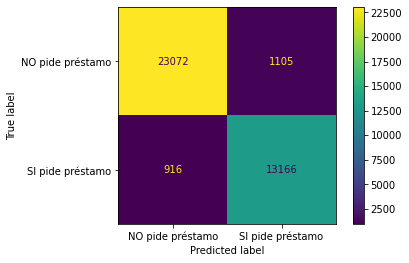

In [22]:
# Predecimos y graficamos la matriz de reporte para la Regresión Logística
y_test_pred_reg = reg_model.predict(X_test)

print(classification_report(y_test, y_test_pred_reg))
plot_confusion_matrix(reg_model, X_test, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     24177
           1       0.99      1.00      1.00     14082

    accuracy                           1.00     38259
   macro avg       1.00      1.00      1.00     38259
weighted avg       1.00      1.00      1.00     38259



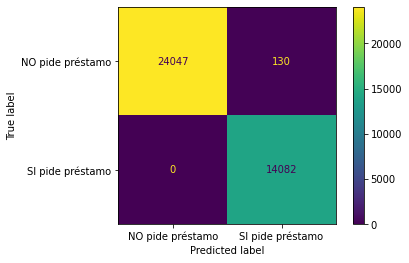

In [23]:
# Predecimos y graficamos la matriz de reporte para el Random Forest
y_test_pred_rf = r_f.predict(X_test)

print(classification_report(y_test, y_test_pred_rf))
plot_confusion_matrix(r_f, X_test, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

### A partir de lo observado anteriormente respecto a la alta precisión de ambos modelos de predicción, podemos concluir que el conjunto de variables elegidas inicialmente es satisfactorio. Estas son:



* 'ANIOS_ANTIGUEDAD',
* 'BANCON_ACTIVO1',
* 'CANTIDAD_PRESTAMOS_HIPOTECARIOS',
* 'CANTIDAD_PRODUCTOS',
* 'CLASIFICACIONCLIENTE',
* 'CLASIFICACION_VALOR_MAC',
* 'Canal_Comercializacion',
* 'EDAD',
* 'INGRESO',
* 'NSE',
* 'SEGMENTO360',
* 'SEXO',
* 'SUCURSAL_ACREDITACION',
* 'TIENE_CAJA_AHORRO',
* 'TIENE_CAJA_SEGURIDAD',
* 'TIENE_DOLARES',
* 'TIENE_FONDO_COMUN_INVERSION',
* 'TIENE_PLAZO_FIJO',
* 'TIENE_PRESTAMO_HIPOTECARIO',
* 'TIENE_SEGURO_PATRIMONIAL',
* 'TIENE_SEGURO_VIDA',
* 'TIENE_TARJETA_CREDITO',
* 'USA_CUENTA_ADELANTO',
* 'USA_CUENTA_CORRIENTE',
* 'UTILIZACION_TC',
* 'UTILIZACION_TD'}

#### A partir de este resultado, buscaremos reducir las variables elegidas para entrenar nuestros modelos y evaluar sus resultados.

## ELECCIÓN de MÉTRICA y VARIABLES SIGNIFICATIVAS

En este tipo de problema, además de tener buena Accuracy, es posible que se quiera minimizar la cantidad de clientes que el modelo erróneamente predice que no pedirán un préstamo y en realidad si lo solicitan ya que no se debería dejar de presentar los productos a aquellos clientes. Para esto se busca minimizar los "falsos negativos", es decir las entradas de abajo a la izquierda de la matriz de confusión.

#### De esta manera, si:

A = Verdaderos positivos = SI pide préstamo bien predecido

D = Verdaderos negativos = NO pide préstamo bien predecidos

B = Falsos negativos = SI pide préstamo predecido como NO pide préstamo

C = Falsos positivos = No pide préstamo predecido como Si pide préstamo

### Entonces

1) A + B es constante, es la cantidad de clientes si piden un préstamo (aquí, 14.082)

2) C + D es constante, es la cantidad de clientes no piden un préstamo (aquí, 24.177)

3) A+B+C+D = 38259, el tamaño total del conjunto de test

Queremos maximizar A + D (las predicciones correctas), y al mismo tiempo minimizar B.

Pero minimizar B es maximizar A pues la suma de ambas es constante. Luego, buscamos maximizar D y minimizar B. Esto equivale a maximizar la métrica:
### $$\frac{D}{D+B}$$


In [24]:
#Métrica para el Modelo de Regresión Logística 
D, C, B, A = confusion_matrix(y_test, y_test_pred_reg).ravel()
D/(D+B)

0.9618142404535601

In [25]:
#Métrica para el Modelo Random Forest
D, C, B, A = confusion_matrix(y_test, y_test_pred_rf).ravel()
D/(D+B)

1.0

### Con el objetivo de reducir la cantidad de variables consideradas en nuestro DataSet, tomaremos la información recabada en la fase de exploración con respecto a los COEFICIENTES DE CORRELACIÓN entre el TARGET y el resto de las variables. 


#### Primer caso : solo consideramos que se tienen datos de 'AÑOS DE ANTIGÜEDAD', 'EDAD' y 'CLASIFICACION_VALOR_MAC' de los clientes:

In [26]:
columnas_signif1 = ['ANIOS_ANTIGUEDAD', 'EDAD', 'CLASIFICACION_VALOR_MAC']
df_reduced1 = df[columnas_signif1]

In [27]:
y = df[target_col]
X1 = df_reduced1

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

Hacemos un escalado de las variables en nuestro Data Set:

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [29]:
model_name='LogisticRegression'
reg_model1 = LogisticRegression(penalty='none')
reg_model1.fit(X_train_scaled,y_train)
score_reg1 = reg_model1.score(X_val_scaled,y_val)

print(f'{model_name} accuracy score: {score_reg1:.4}\n')

LogisticRegression accuracy score: 0.9357



In [30]:
test=False
model_name="RF"

r_f1 = RandomForestClassifier()
r_f1.fit(X_train_scaled,y_train)
score_RF1 = r_f1.score(X_val_scaled, y_val)
print(f'{model_name} accuracy score: {score_RF1:.4}\n')

RF accuracy score: 0.9393



              precision    recall  f1-score   support

           0       0.95      0.95      0.95     24177
           1       0.92      0.91      0.91     14082

    accuracy                           0.94     38259
   macro avg       0.93      0.93      0.93     38259
weighted avg       0.94      0.94      0.94     38259



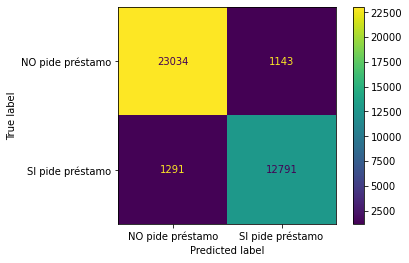

In [31]:
# Predecimos y graficamos la matriz de reporte para la Regresión Logística
y_pred_reg1 = reg_model1.predict(X_test_scaled)

print(classification_report(y_test, y_pred_reg1))
plot_confusion_matrix(reg_model1, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     24177
           1       0.94      0.90      0.92     14082

    accuracy                           0.94     38259
   macro avg       0.94      0.93      0.93     38259
weighted avg       0.94      0.94      0.94     38259



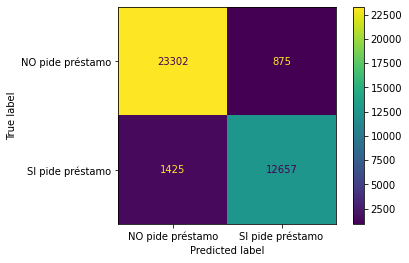

In [32]:
# Predecimos y graficamos la matriz de reporte para el Random Forest
y_pred_rf1 = r_f1.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf1))
plot_confusion_matrix(r_f1, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

In [33]:
#Métrica para el modelo de Regresión Logística con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_reg1).ravel()
D/(D+B)

0.9469270298047276

In [34]:
#Métrica para el modelo Random Forest con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_rf1).ravel()
D/(D+B)

0.9423706879119991

### Es para destacar la excelente performance lograda a partir de estas únicas tres variables con respecto a conseguir un alto valor en nuestra métrica.

#### Segundo caso, se consideran variables relacionadas a los productos del banco que tienen los clientes. Aquí solo consideramos que se tienen datos de las variables: 'CANTIDAD_PRODUCTOS' y 'TIENE_SEGURO_VIDA'.

In [35]:
columnas_signif2 = ['CANTIDAD_PRODUCTOS', 'TIENE_SEGURO_VIDA']
df_reduced2 = df[columnas_signif2]

In [36]:
y = df[target_col]
X2 = df_reduced2

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

Hacemos un escalado de las variables en nuestro Data Set:

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [38]:
model_name='LogisticRegression'
reg_model2 = LogisticRegression(penalty='none')
reg_model2.fit(X_train_scaled,y_train)
score_reg2 = reg_model2.score(X_val_scaled,y_val)

print(f'{model_name} accuracy score: {score_reg2:.4}\n')

LogisticRegression accuracy score: 0.7458



In [39]:
test=False
model_name="RF"

r_f2 = RandomForestClassifier()
r_f2.fit(X_train_scaled,y_train)
score_RF2 = r_f2.score(X_val_scaled, y_val)
print(f'{model_name} accuracy score: {score_RF2:.4}\n')

RF accuracy score: 0.7458



              precision    recall  f1-score   support

           0       0.75      0.90      0.82     24177
           1       0.73      0.49      0.58     14082

    accuracy                           0.75     38259
   macro avg       0.74      0.69      0.70     38259
weighted avg       0.74      0.75      0.73     38259



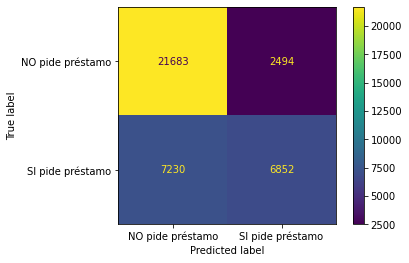

In [40]:
# Predecimos y graficamos la matriz de reporte para la Regresión Logística
y_pred_reg2 = reg_model2.predict(X_test_scaled)

print(classification_report(y_test, y_pred_reg2))
plot_confusion_matrix(reg_model2, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

              precision    recall  f1-score   support

           0       0.75      0.90      0.82     24177
           1       0.73      0.49      0.58     14082

    accuracy                           0.75     38259
   macro avg       0.74      0.69      0.70     38259
weighted avg       0.74      0.75      0.73     38259



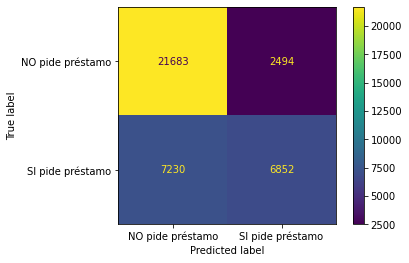

In [41]:
# Predecimos y graficamos la matriz de reporte para el Random Forest
y_pred_rf2 = r_f2.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf2))
plot_confusion_matrix(r_f2, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

In [42]:
#Métrica para el modelo de Regresión Logística con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_reg2).ravel()
D/(D+B)

0.7499394735931934

In [43]:
#Métrica para el modelo Random Forest con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_rf2).ravel()
D/(D+B)

0.7499394735931934

### Se evidencia que esta elección de variables, al ser muy reducida, es una buena elección más allá de que la métrica no tenga un valor alto.

#### Tercer caso, se consideran variables relacionadas a la utilización de los productos del banco que tienen los clientes. Aquí solo consideramos que se tienen datos de las variables: 'UTILIZACIÓN DE TARJETA DE CRÉDITO' y 'USA_CUENTA_ADELANTO'.

In [44]:
columnas_signif3 = ['UTILIZACION_TC', 'USA_CUENTA_ADELANTO']
df_reduced3 = df[columnas_signif3]

In [45]:
y = df[target_col]
X3 = df_reduced3

X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

Hacemos un escalado de las variables en nuestro Data Set:

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [47]:
model_name='LogisticRegression'
reg_model3 = LogisticRegression(penalty='none')
reg_model3.fit(X_train_scaled,y_train)
score_reg3 = reg_model3.score(X_val_scaled,y_val)

print(f'{model_name} accuracy score: {score_reg3:.4}\n')

LogisticRegression accuracy score: 0.6986



In [48]:
test=False
model_name="RF"

r_f3 = RandomForestClassifier()
r_f3.fit(X_train_scaled,y_train)
score_RF3 = r_f3.score(X_val_scaled, y_val)
print(f'{model_name} accuracy score: {score_RF3:.4}\n')

RF accuracy score: 0.6986



              precision    recall  f1-score   support

           0       0.72      0.85      0.78     24177
           1       0.62      0.42      0.50     14082

    accuracy                           0.69     38259
   macro avg       0.67      0.64      0.64     38259
weighted avg       0.68      0.69      0.68     38259



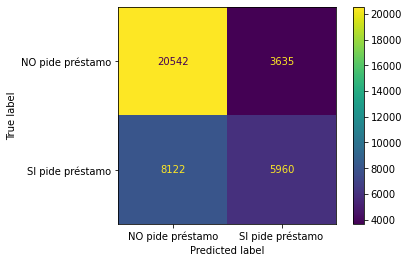

In [49]:
# Predecimos y graficamos la matriz de reporte para la Regresión Logística
y_pred_reg3 = reg_model3.predict(X_test_scaled)

print(classification_report(y_test, y_pred_reg3))
plot_confusion_matrix(reg_model3, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

              precision    recall  f1-score   support

           0       0.72      0.85      0.78     24177
           1       0.62      0.42      0.50     14082

    accuracy                           0.69     38259
   macro avg       0.67      0.64      0.64     38259
weighted avg       0.68      0.69      0.68     38259



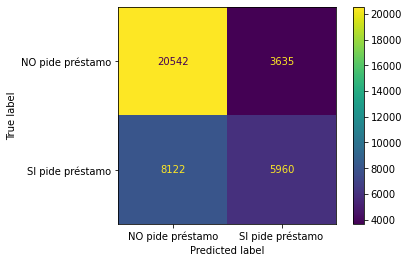

In [50]:
# Predecimos y graficamos la matriz de reporte para el Random Forest
y_pred_rf3 = r_f3.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf3))
plot_confusion_matrix(r_f3, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

In [51]:
#Métrica para el modelo de Regresión Logística con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_reg3).ravel()
D/(D+B)

0.7166480602846776

In [52]:
#Métrica para el modelo Random Forest con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_rf3).ravel()
D/(D+B)

0.7166480602846776

### Se observa que este elección de variables otorga la peor medida en la métrica elegida.

#### Cuarto caso, con la intención de mejorar la métrica en los dos últimos casos, se consideran todas las variables relacionadas a los productos del banco que tienen los clientes. Se consideran las variables: 'CANTIDAD_PRODUCTOS', 'TIENE_SEGURO_VIDA', 'UTILIZACIÓN DE TARJETA DE CRÉDITO' y 'USA_CUENTA_ADELANTO'.

In [53]:
columnas_signif4 = ['CANTIDAD_PRODUCTOS', 'TIENE_SEGURO_VIDA', 'UTILIZACION_TC', 'USA_CUENTA_ADELANTO']
df_reduced4 = df[columnas_signif4]

In [54]:
y = df[target_col]
X4 = df_reduced4

X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [56]:
model_name='LogisticRegression'
reg_model4 = LogisticRegression(penalty='none')
reg_model4.fit(X_train_scaled,y_train)
score_reg4 = reg_model4.score(X_val_scaled,y_val)

print(f'{model_name} accuracy score: {score_reg4:.4}\n')

LogisticRegression accuracy score: 0.7458



In [57]:
test=False
model_name="RF"

r_f4 = RandomForestClassifier()
r_f4.fit(X_train_scaled,y_train)
score_RF4 = r_f4.score(X_val_scaled, y_val)
print(f'{model_name} accuracy score: {score_RF4:.4}\n')

RF accuracy score: 0.7853



              precision    recall  f1-score   support

           0       0.75      0.90      0.82     24177
           1       0.73      0.49      0.58     14082

    accuracy                           0.75     38259
   macro avg       0.74      0.69      0.70     38259
weighted avg       0.74      0.75      0.73     38259



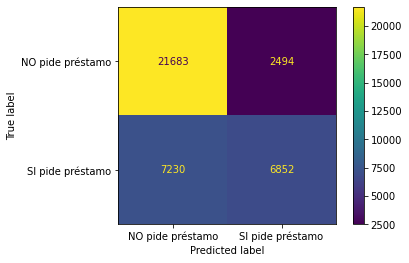

In [59]:
# Predecimos y graficamos la matriz de reporte para la Regresión Logística
y_pred_reg4 = reg_model4.predict(X_test_scaled)

print(classification_report(y_test, y_pred_reg4))
plot_confusion_matrix(reg_model4, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     24177
           1       0.74      0.65      0.69     14082

    accuracy                           0.79     38259
   macro avg       0.77      0.76      0.77     38259
weighted avg       0.78      0.79      0.78     38259



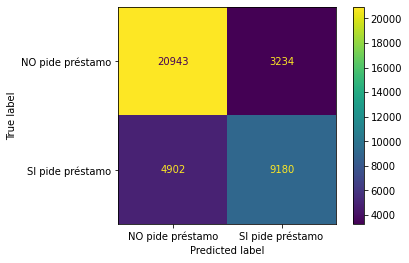

In [60]:
# Predecimos y graficamos la matriz de reporte para el Random Forest
y_pred_rf4 = r_f4.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf4))
plot_confusion_matrix(r_f4, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

In [61]:
#Métrica para el modelo de Regresión Logística con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_reg4).ravel()
D/(D+B)

0.7499394735931934

In [62]:
#Métrica para el modelo Random Forest con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_rf4).ravel()
D/(D+B)

0.8103308183401045

### Se concluye que agregar las variables del caso 3 a las del caso 4 no aporta una mejora significativa en la métrica elegida (solamente mejoró el modelo de RF4 respecto al RF2).

#### Último caso: se consideran las 5 variables significativas: 'AÑOS_ANTIGUEDAD', 'EDAD', 'CLASIFICACION_VALOR_MAC', 'CANTIDAD_PRODUCTOS' y 'TIENE_SEGURO_VIDA'.

In [73]:
columnas_signif5 = ['ANIOS_ANTIGUEDAD', 'EDAD', 'CLASIFICACION_VALOR_MAC','CANTIDAD_PRODUCTOS', 'TIENE_SEGURO_VIDA']
df_reduced5 = df[columnas_signif5]

In [74]:
y = df[target_col]
X5 = df_reduced5

X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [76]:
model_name='LogisticRegression'
reg_model5 = LogisticRegression(penalty='none')
reg_model5.fit(X_train_scaled,y_train)
score_reg5 = reg_model5.score(X_val_scaled,y_val)

print(f'{model_name} accuracy score: {score_reg5:.4}\n')

LogisticRegression accuracy score: 0.9547



In [77]:
test=False
model_name="RF"

r_f5 = RandomForestClassifier()
r_f5.fit(X_train_scaled,y_train)
score_RF5 = r_f5.score(X_val_scaled, y_val)
print(f'{model_name} accuracy score: {score_RF5:.4}\n')

RF accuracy score: 0.9597



              precision    recall  f1-score   support

           0       0.96      0.97      0.97     24177
           1       0.94      0.94      0.94     14082

    accuracy                           0.96     38259
   macro avg       0.95      0.95      0.95     38259
weighted avg       0.96      0.96      0.96     38259



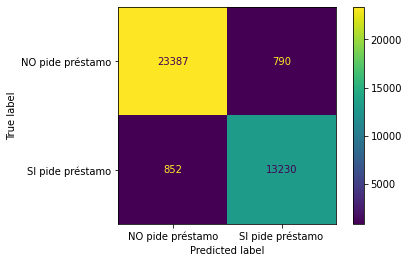

In [78]:
# Predecimos y graficamos la matriz de reporte para la Regresión Logística
y_pred_reg5 = reg_model5.predict(X_test_scaled)

print(classification_report(y_test, y_pred_reg5))
plot_confusion_matrix(reg_model5, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     24177
           1       0.94      0.95      0.95     14082

    accuracy                           0.96     38259
   macro avg       0.96      0.96      0.96     38259
weighted avg       0.96      0.96      0.96     38259



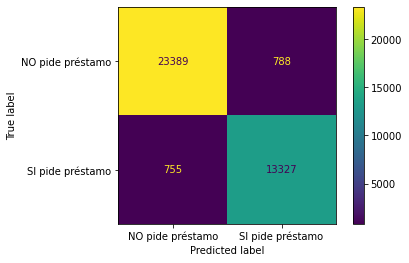

In [79]:
# Predecimos y graficamos la matriz de reporte para el Random Forest
y_pred_rf5 = r_f5.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf5))
plot_confusion_matrix(r_f5, X_test_scaled, y_test, display_labels=['NO pide préstamo', 'SI pide préstamo'])

In [80]:
#Métrica para el modelo de Regresión Logística con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_reg5).ravel()
D/(D+B)

0.9648500350674533

In [81]:
#Métrica para el modelo Random Forest con el primer subconjunto de VARIABLES SIGNIFICATIVAS
D, C, B, A = confusion_matrix(y_test, y_pred_rf5).ravel()
D/(D+B)

0.9687292909211398

## La CONCLUSIÓN final que se obtiene es que las 5 variables consideradas en el último caso ('AÑOS_ANTIGÜEDAD', 'EDAD', 'CLASIFICACION_VALOR_MAC', 'CANTIDAD_PRODUCTOS' y 'TIENE_SEGURO_VIDA') son lo suficientemente significativas como para prescindir del resto ya que el valor obtenido en la métrica propuesta alcanza un valor significativante elevado. 